# Twitter Dataset

In this notebook, we apply the backdoor adjustment method to a dataset extracted from Twitter and stored in MongoDB.

In [1]:
from pymongo import MongoClient
import urllib
from bson.code import Code
from bson.son import SON
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from datetime import datetime
import sys
import pickle
from scipy.stats import pearsonr, sem
import re

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline

## Users distribution

In [440]:
mongo = MongoClient()

In [2]:
def plot_tweets_count():
    ny_tweets_count = []
    la_tweets_count = []
    for user in mongo.users.gender_ny_m100_f220.find({}):
        ny_tweets_count.append(int(user['value']['statuses']))
    for user in mongo.users.gender_la_m100_f220.find({}):
        la_tweets_count.append(int(user['value']['statuses']))

    fig, ax = plt.subplots(figsize=[12,6])
    data = [ny_tweets_count, la_tweets_count]
    colors = ['navy', 'crimson']
    h_ny = plt.hist(data, bins=30, color=colors)
    plt.legend(['New York', 'Los Angeles'], loc='upper right')
    # ax.set_ylim([0,5200])
    ax.set_xlabel('# tweets')
    ax.set_ylabel('# users')
    plt.show()

def plot_gender_count():
    ny_gender_count = defaultdict(int)
    la_gender_count = defaultdict(int)
    for user in mongo.users.gender_ny_m100_f220.find({}):
        ny_gender_count[user['value']['gender']] += 1
    for user in mongo.users.gender_la_m100_f220.find({}):
        la_gender_count[user['value']['gender']] += 1

    fig, ax = plt.subplots(figsize=[12,6])
    colors = ['navy', 'crimson']
    width=.35
    ind = np.arange(2)
    rm = plt.bar(ind,
            (ny_gender_count['m'], la_gender_count['m']), width,
            color=colors[0])
    rf = plt.bar(ind+width,
            (ny_gender_count['f'], la_gender_count['f']), width,
            color=colors[1])
    plt.legend((rm, rf), ('Men', 'Women'), loc='upper right')
    # ax.set_ylim([0,5200])
    ax.set_xticks(ind+width)
    ax.set_xticklabels(['New York', 'Los Angeles'])
    plt.show()

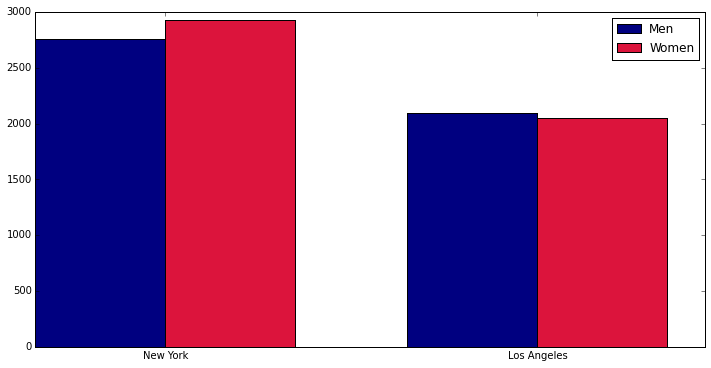

In [253]:
plot_gender_count()

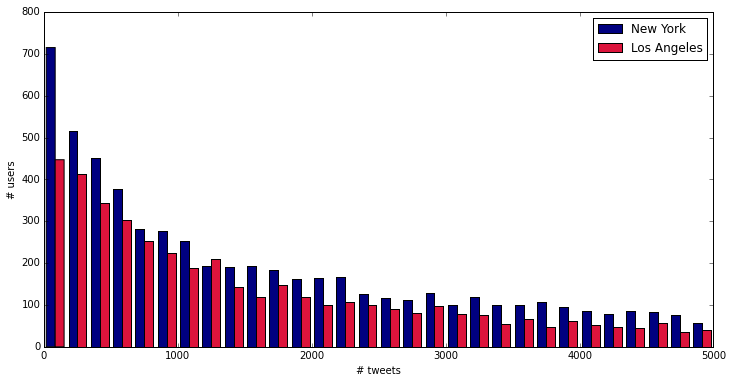

In [210]:
plot_tweets_count()

## Load dataset

The process of creating the dataset from 6000 users takes ~2 hours. Therefore, the results have been pickled and can be reloaded in ordered to get the dataset.

In [3]:
class Data(object):
    pass

def load_dataset(users_pkl, term_doc_matrix_pkl, vectorizer_pkl=None, confounder_key='gender',
                 train_ratio=.5, rand=np.random.RandomState(111191)):
    data = Data()
    if vectorizer_pkl is not None:
        print("Loading feature names through vectorizer...")
        with open(vectorizer_pkl, 'rb') as f:
            vec = pickle.load(f)
        data.feature_names = np.array(vec.get_feature_names())
    print("Loading users pickle...")
    with open(users_pkl, 'rb') as f:
        all_users = pickle.load(f)
    print("Load term document matrix pickle...")
    with open(term_doc_matrix_pkl, 'rb') as f:
        X = pickle.load(f)
    print("Getting label and confounder for every user...")
    Y = []
    C = []
    label_key = 'location' if confounder_key == 'gender' else 'gender'
    for city_users in all_users:
        for u in city_users:
            C.append(u[confounder_key])
            Y.append(u[label_key])
    print("Done")
    print("%d users, %d features" % X.shape)
    C_set = set(C)
    Y_set = set(Y)
    for dc in C_set:
        for dy in Y_set:
            print("\tc = %s and y = %s: %d users" % (dc, dy, len([i for i in range(len(Y)) if Y[i]==dy and C[i]==dc])))
            
    le_C = preprocessing.LabelEncoder()
    le_Y = preprocessing.LabelEncoder()
    C_int = le_C.fit_transform(C)
    Y_int = le_Y.fit_transform(Y)
    print(le_C.classes_)
    print(le_Y.classes_)
    
    indices = list(range(X.shape[0]))
    rand.shuffle(indices)
    train_size = int(train_ratio * X.shape[0])
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]
    
    data.train_x = X[train_idx]
    data.test_x = X[test_idx]
    data.train_c = C_int[train_idx]
    data.test_c = C_int[test_idx]
    data.train_y = Y_int[train_idx]
    data.test_y = Y_int[test_idx]
    
    print('lengths: x_train %d y_train %d c_train %d' % (data.train_x.shape[0], data.train_y.shape[0], data.train_c.shape[0]))
    print('train y distr', Counter(data.train_y), 'c distr', Counter(data.train_c))
    print('train y and c distr', Counter(['y=%d,c=%d' % (y,c) for (y,c) in zip(data.train_y,data.train_c)]))
    
    print('lengths: x_test %d y_test %d c_test %d' % (data.test_x.shape[0], data.test_y.shape[0], data.test_c.shape[0]))
    print('test y distr', Counter(data.test_y), 'c distr', Counter(data.test_c))
    print('test y and c distr', Counter(['y=%d,c=%d' % (y,c) for (y,c) in zip(data.test_y,data.test_c)]))
    
    return data

## Experiments

In [4]:
%run models.py
%run injecting_bias.py
%run confound_plot.py
%run most_changing_coef.py
%run ba_c_study.py

In [9]:
backdoor_adjustment = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,1.)
backdoor_adjustment_Z10 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,10)

In [6]:
def do_confounding_trials(models, data, ntrials, rand):  
    """ Do several random trials in which we sample data with a confounding variable. 
    Plot the average accuracies as confounding bias increases.
    """
    test_biases = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    train_biases = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
    
#     test_biases = [.1, .5, .9]
#     train_biases = [.1, .5, .9]
    corr_diffs = []
    accuracies = defaultdict(lambda: defaultdict(lambda: []))
    
    for train_bias in train_biases:
        for test_bias in test_biases:
            for ti in range(ntrials):
                # Sample training and testing indices.
                test_idx = make_confounding_data(X=data.test_x, y=data.test_y, c=data.test_c,
                                                pos_prob=.5, bias=test_bias, size=800, rand=rand)  
                test_corr = pearsonr(data.test_y[test_idx], data.test_c[test_idx])[0]
                train_idx = make_confounding_data(X=data.train_x, y=data.train_y, c=data.train_c,
                                                  pos_prob=.5, bias=train_bias, size=800, rand=rand)   
                train_corr = pearsonr(data.train_y[train_idx], data.train_c[train_idx])[0]
                corr_diff = round(train_corr - test_corr, 1)
                if ti == 0:
                    corr_diffs.append(corr_diff)
                    print('train_bias=', train_bias, 'train_corr=', train_corr,
                          'test_bias=', test_bias, 'test_corr=', test_corr,
                          'corr_diff=', corr_diff)
                    
                # Train and test each model.
                for name, model in models:
                    clf = model(data.train_x[train_idx], data.train_y[train_idx],
                                data.train_c[train_idx], rand, data.feature_names)
                    y_pred = clf.predict(data.test_x[test_idx])
                    y_true = data.test_y[test_idx]
                    for y in range(3):
                        for c in range(3):
                            k = 3*y+c
                            cond = lambda x: (c == 2 or data.test_c[x] == c) and (y == 2 or data.test_y[x] == y)
                            yc_test_idx = [i for i, j in enumerate(test_idx) if cond(j)]
                            accuracies[k][name].append({'test_bias': test_bias, 'train_bias': train_bias,
                                                        'corr_diff': corr_diff,
                                                        'acc': accuracy_score(y_true[yc_test_idx],
                                                                              y_pred[yc_test_idx])})
                        
    return accuracies, corr_diffs, test_biases

In [10]:
def do_confound_expt(data, ntrials=3, models=[('feature_select', feature_select),('logreg', lr),              
                                             ('matching', matching),('backdoor_adjustment', backdoor_adjustment)],
                    confounding_function=do_confounding_trials):                                              
    rand = np.random.RandomState(1234567)                                                                     
    clf = lr(data.train_x, data.train_y, data.train_c, rand, data.feature_names)                              
    print('og testing accuracy=', accuracy_score(data.test_y, clf.predict(data.test_x)))                      
    print('----------------\nExperiments using genre as a confounder:')                                       
    return confounding_function(models, data, ntrials, rand)

### Predict location with gender as a confounder

#### Accuracy experiment

In [12]:
data = load_dataset(users_pkl="/data/2/confound/users_array.pkl",
                    term_doc_matrix_pkl="/data/2/confound/term_doc_matrix.pkl",
                    vectorizer_pkl="/data/2/confound/vectorizer.pkl",
                    confounder_key='gender',
                    train_ratio=.5)

Loading feature names through vectorizer...
Loading users pickle...
Load term document matrix pickle...
Getting label and confounder for every user...
Done
6000 users, 21981 features
	c = f and y = ny: 1500 users
	c = f and y = la: 1500 users
	c = m and y = ny: 1500 users
	c = m and y = la: 1500 users
['f' 'm']
['la' 'ny']
lengths: x_train 3000 y_train 3000 c_train 3000
train y distr Counter({0: 1527, 1: 1473}) c distr Counter({1: 1511, 0: 1489})
train y and c distr Counter({'y=0,c=1': 772, 'y=0,c=0': 755, 'y=1,c=1': 739, 'y=1,c=0': 734})
lengths: x_test 3000 y_test 3000 c_test 3000
test y distr Counter({1: 1527, 0: 1473}) c distr Counter({0: 1511, 1: 1489})
test y and c distr Counter({'y=1,c=0': 766, 'y=1,c=1': 761, 'y=0,c=0': 745, 'y=0,c=1': 728})


In [32]:
' '.join(fts)

-1

In [40]:
models = [('LR', lr), ('M', matching), ('BA', backdoor_adjustment), ('SO', sumout), ('LRS', lr_subsampling),
          ('BAZ10', backdoor_adjustment_Z10)]
accuracies, corr_diffs, test_biases = do_confound_expt(data, ntrials=5, models=models)

og testing accuracy= 0.883
----------------
Experiments using genre as a confounder:
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.1 test_corr= -0.795039752981 corr_diff= -0.0
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.2 test_corr= -0.595029752231 corr_diff= -0.2
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.3 test_corr= -0.395019751481 corr_diff= -0.4
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.4 test_corr= -0.20001000075 corr_diff= -0.6
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.5 test_corr= 0.0 corr_diff= -0.8
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.6 test_corr= 0.20001000075 corr_diff= -1.0
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.7 test_corr= 0.395019751481 corr_diff= -1.2
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.8 test_corr= 0.595029752231 corr_diff= -1.4
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.9 test_corr= 0.795039752981 corr_diff= -1.6
train_bias= 0.2

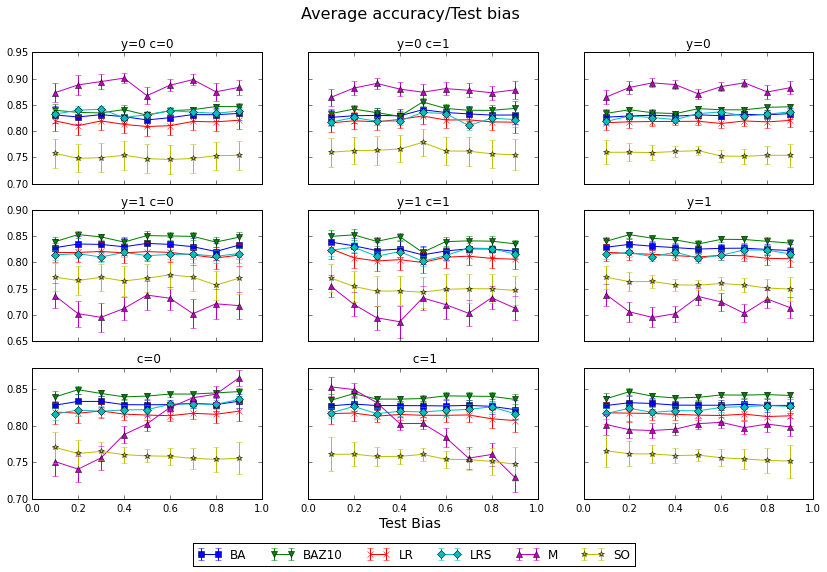

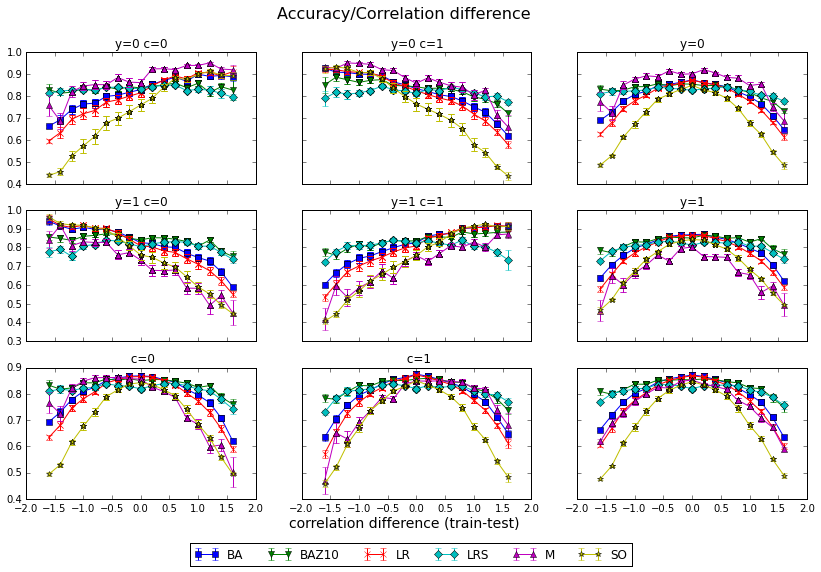

In [41]:
test_bias_axis = (test_biases, 'test_bias', 'Test Bias')
corr_diff_axis = (corr_diffs, 'corr_diff', 'correlation difference (train-test)')

to_plot = ['logistic regression']
plot_all_accuracies(accuracies, test_bias_axis, title='Average accuracy/Test bias', xlim=[0,1])#, keys=to_plot)
plot_all_accuracies(accuracies, corr_diff_axis, title='Accuracy/Correlation difference')#, keys=to_plot)

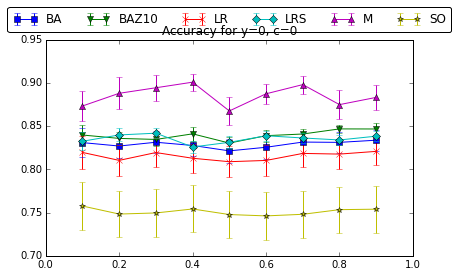

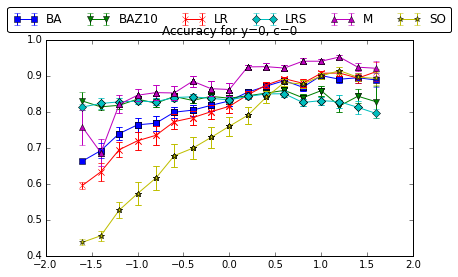

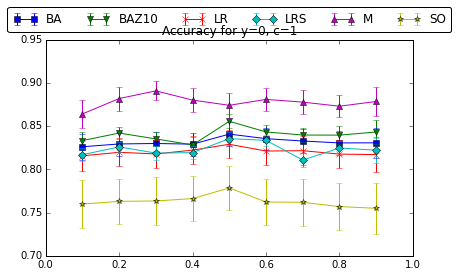

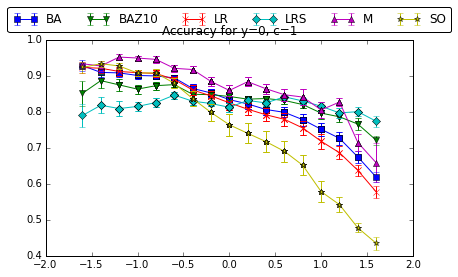

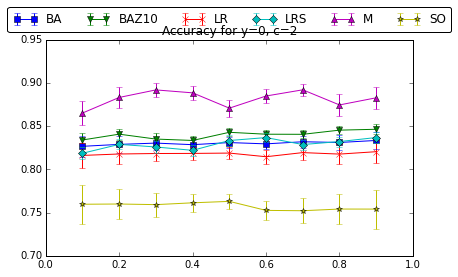

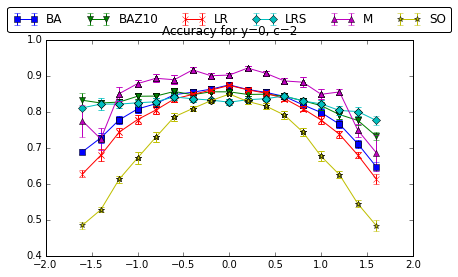

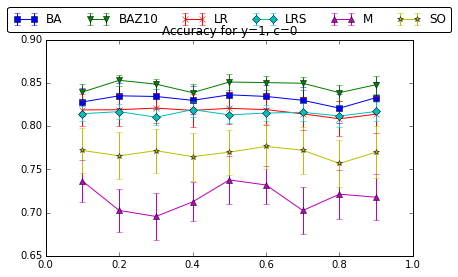

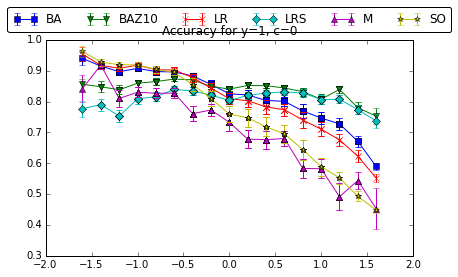

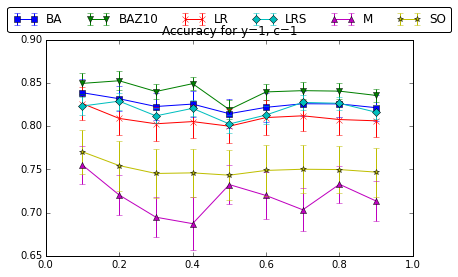

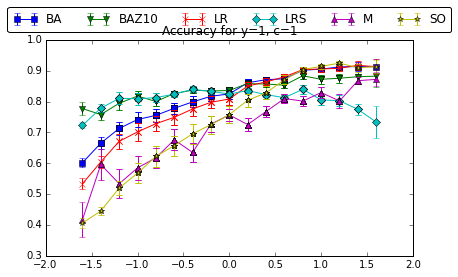

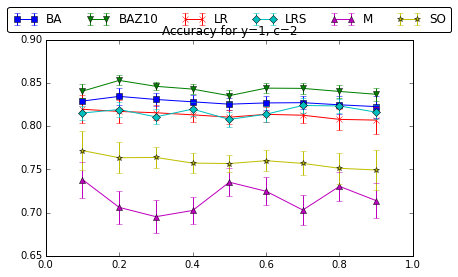

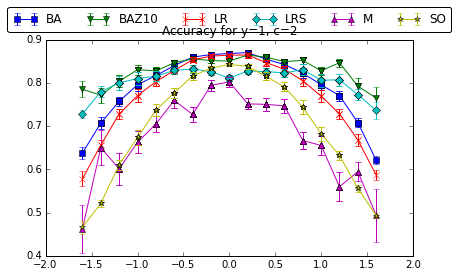

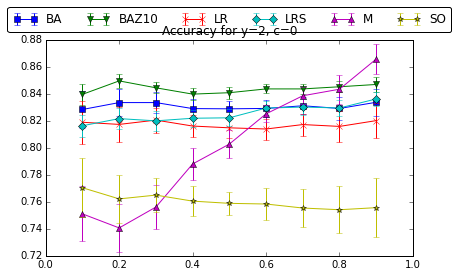

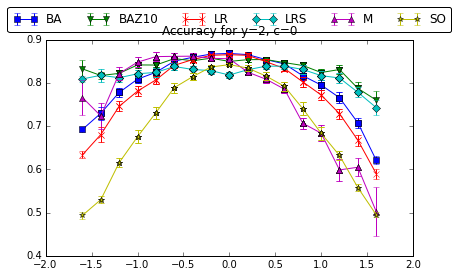

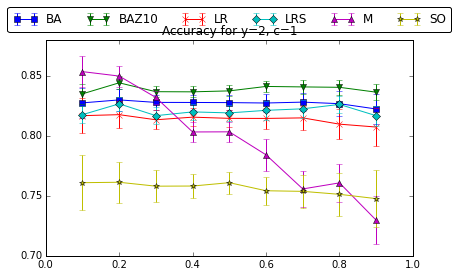

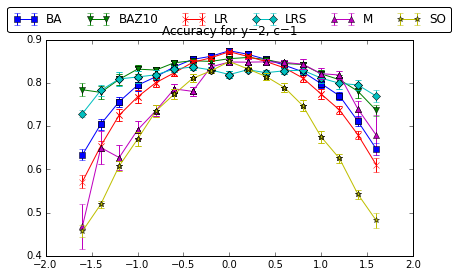

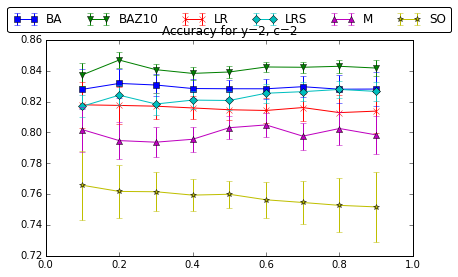

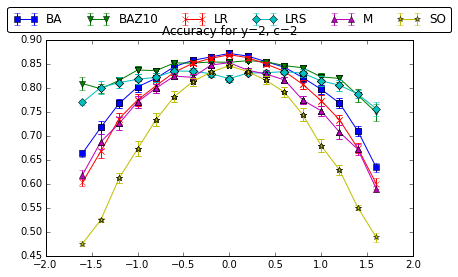

In [42]:
for y in range(3):
    for c in range(3):
        plot_accuracy(accuracies, test_bias_axis, y=y, c=c, xlim=[0,1])
        plot_accuracy(accuracies, corr_diff_axis, y=y, c=c)

#### Export figures

/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:95: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


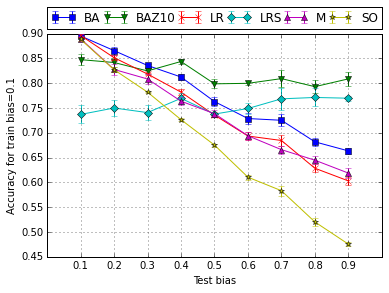

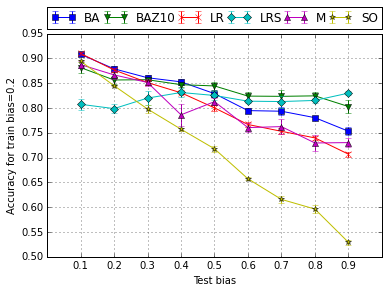

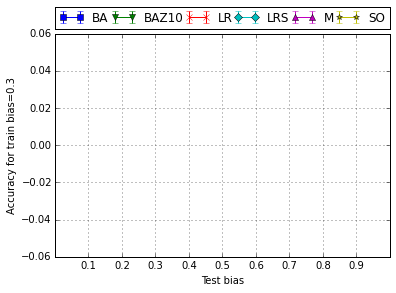

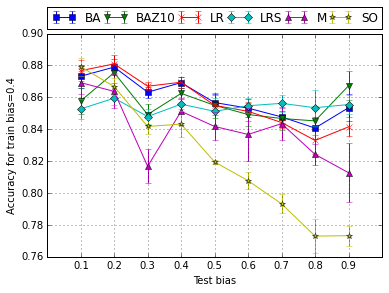

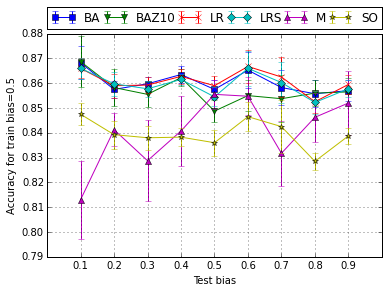

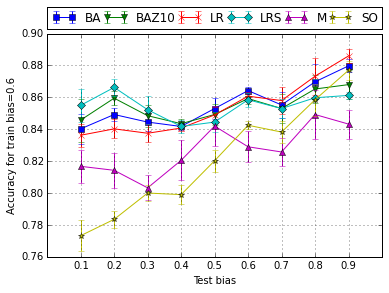

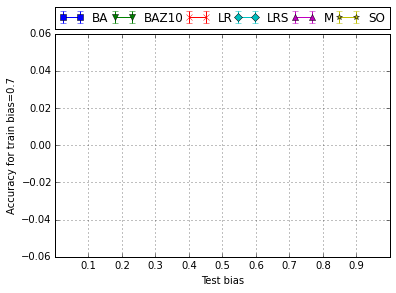

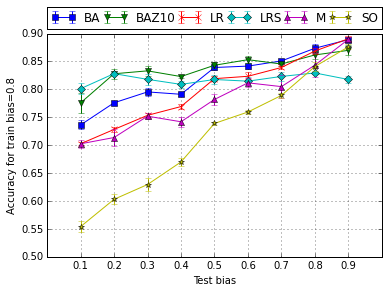

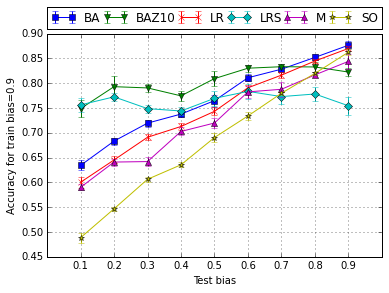

In [43]:
for tr_bias in np.arange(0.1, 1., 0.1):
    ylabel="Accuracy for train bias=%.1f" % tr_bias
    export_plot_accuracy('test', accuracies, test_bias_axis, 2, 2, title='', xlabel='Test bias', train_bias=tr_bias,
                         ylabel=ylabel, xlim=[0.,1.], set_xticks=np.arange(0.1,1.,.1))

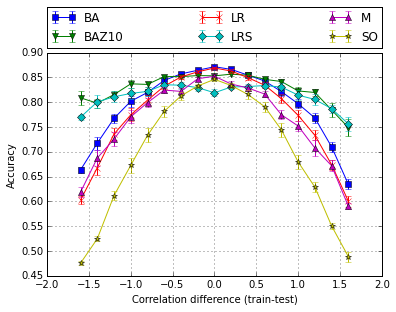

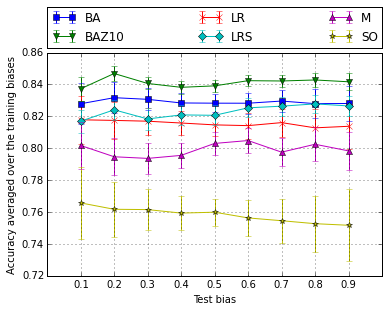

In [44]:
toplot = ['BA', 'BAZ10', 'LR', 'M', 'LRS']

# Export IMDb plots
fig = export_plot_accuracy('../paper/figures/twitter_accuracy_corr_diff.pdf',
                           accuracies, corr_diff_axis, 2, 2, title='',
                           xlabel='Correlation difference (train-test)', ncol=3,
                           ylabel='Accuracy')

fig = export_plot_accuracy('../paper/figures/twitter_accuracy_test_bias.pdf',
                           accuracies, test_bias_axis, 2, 2, title='', ncol=3,
                           xlabel='Test bias',
                           ylabel='Accuracy averaged over the training biases', xlim=[0.,1.], set_xticks=np.arange(0.1,1.,.1))

#### Simpson's paradox

In [8]:
%run simpson_paradox.py

In [ ]:
methods = [('BAZ10', backdoor_adjustment_Z10), ('LR', lr), ('LRS', lr_subsampling), ('BA', backdoor_adjustment)]
rand = np.random.RandomState(111191)
biases, spa_count_bias_results = simpson_paradox_count_bias(data, methods, 800, rand=rand)

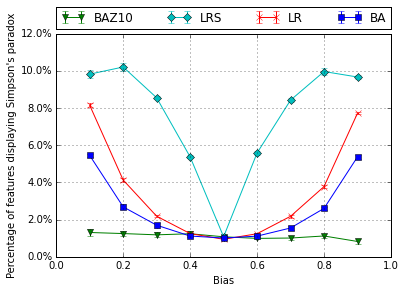

In [20]:
markers = {
    'BAZ10': 'gv-',
    'LR': 'rx-',
    'BA': 'bs-',
    'LRS': 'cD-'
}
plot_spa_results(biases, spa_count_bias_results, markers, tofile="../paper/figures/simpson_paradox_expt.pdf", n_fts=21981.)

#### Most changing features

In [600]:
%run most_changing_coef.py

bias = 0.1


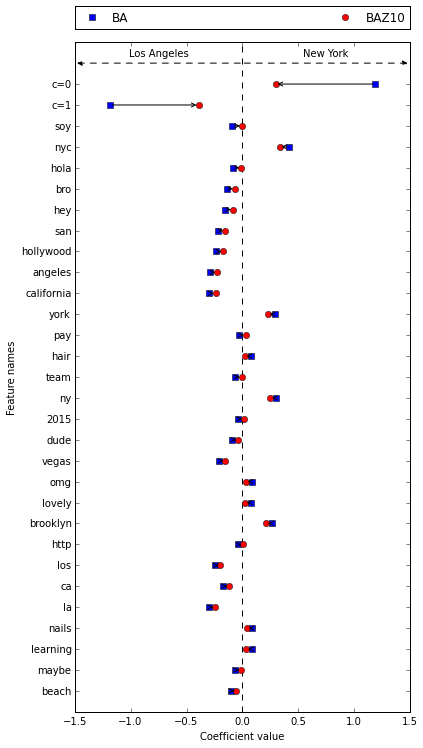

bias = 0.5


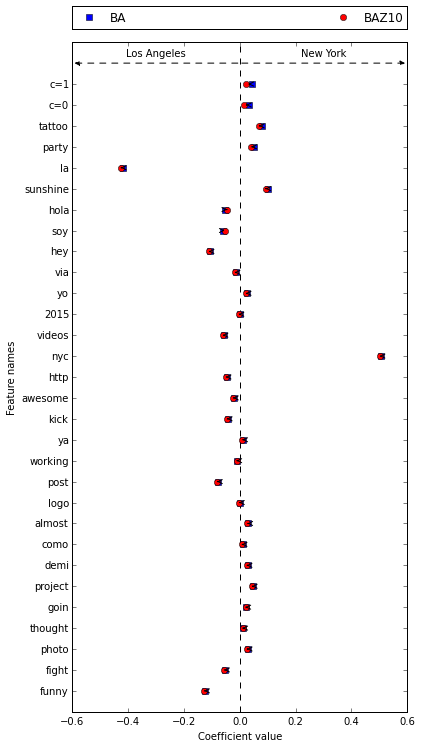

bias = 0.9


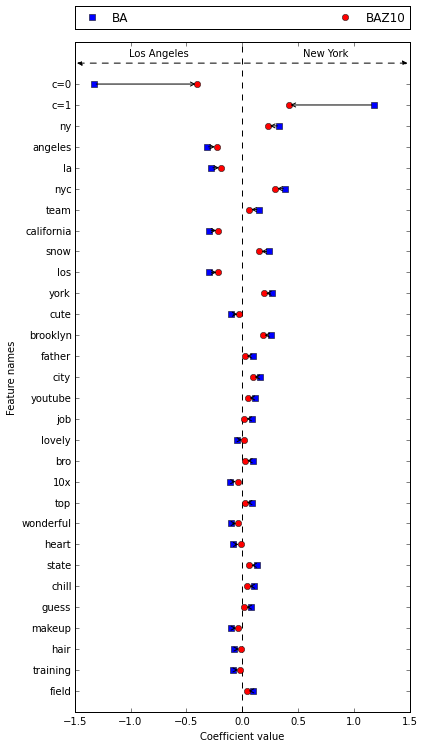

In [601]:
params = dict(data=data,
              n=30,
              models=[(backdoor_adjustment, 'BA'), (backdoor_adjustment_Z10, 'BAZ10')],
              biases=[.1,.5,.9],
              size=800,
              transformation=most_changing_coef,
              class_labels=['Los Angeles', 'New York'],
              feature_names=np.hstack([data.feature_names, ['c=0', 'c=1']]))
changing_coef_plot(**params)

In [64]:
%run most_changing_coef.py

bias = 0.9


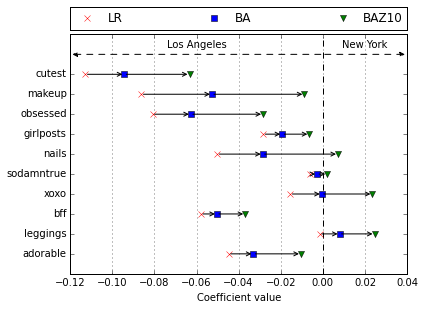

In [63]:
x2, pval = chi2(data.train_x, data.train_c)
top_ft_idx = np.argsort(x2)[::-1][:10][::-1]
params = dict(data=data,
              models=[(lr, 'LR', 'rx'), (backdoor_adjustment, 'BA', 'bs'), (backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.9],
              size=800,
              trials=2,
              class_labels=['Los Angeles', 'New York'],
              indices=top_ft_idx,
              tofile='../paper/figures/twitter_changing_coef_xc_bias90.pdf')
changing_coef_plot_given_idx(**params)

bias = 0.9


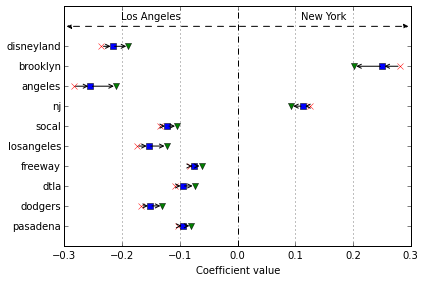

In [65]:
x2, pval = chi2(data.train_x, data.train_y)
top_ft_idx = np.argsort(x2)[::-1][:10][::-1]
params = dict(data=data,
              models=[(lr, 'LR', 'rx'), (backdoor_adjustment, 'BA', 'bs'), (backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.9],
              size=800,
              trials=2,
              class_labels=['Los Angeles', 'New York'],
              indices=top_ft_idx,
              tofile='../paper/figures/twitter_changing_coef_xy_bias90.pdf')
changing_coef_plot_given_idx(**params)

#### Study effect of C on accuracy

In [888]:
c_range = np.logspace(-3, 4, 15)
filter_corr_diff = lambda x: np.abs(x) > 1.2
accuracies_c, coefs_c = do_c_study(c_range, filter_corr_diff, data, 5,
                                   np.random.RandomState(111191), 800, 5)

5 top correlated features: ['cutest' 'makeup' 'obsessed' 'girlposts' 'nails']
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.8 test_corr= 0.595029752231 corr_diff= -1.4
train_bias= 0.1 train_corr= -0.802502507824 test_bias= 0.9 test_corr= 0.795039752981 corr_diff= -1.6
train_bias= 0.2 train_corr= -0.602501882821 test_bias= 0.9 test_corr= 0.795039752981 corr_diff= -1.4
train_bias= 0.8 train_corr= 0.602501882821 test_bias= 0.1 test_corr= -0.795039752981 corr_diff= 1.4
train_bias= 0.9 train_corr= 0.802502507824 test_bias= 0.1 test_corr= -0.795039752981 corr_diff= 1.6
train_bias= 0.9 train_corr= 0.802502507824 test_bias= 0.2 test_corr= -0.595029752231 corr_diff= 1.4


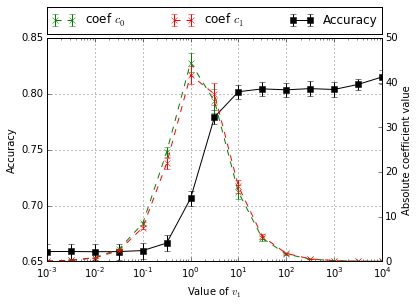

In [890]:
plot_c_study(c_range, accuracies_c, coefs_c, tofile='../paper/figures/ba_c_study.pdf')

#### Top terms table

In [616]:
%run top_terms_table.py

In [726]:
do_top_coef_table(data, lr, 5, 800, 10, np.random.RandomState(111191), 1., feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['cutest' 'makeup' 'obsessed' 'girlposts' 'nails' 'sodamntrue' 'xoxo' 'bff'
 'leggings' 'adorable' 'heels' 'dresses' 'relatablequote' 'mascara'
 'commonwhitegiri' 'nba' 'bestie' 'lebron' 'eyebrows' 'pll'
 'tweetlikeagiri' 'boyfriend' 'thetumblrposts' 'youuu' 'xbox'
 'comedyandtruth' 'friendship' 'sweetest' 'lipstick' 'femalestruggies'
 'eyeliner' 'femaletexts' 'girly' 'gossip' 'playoff' 'diaryforteens'
 'babes' 'kardashianreact' 'franchise' 'cuties' '_ladyboners' 'ily'
 'playoffs' 'espn' 'sincerelytumblr' 'spurs' 'tan' 'dunk' 'mani' 'flowers'
 'sista' 'yay' 'bestfriend' 'happiest' 'nfl' 'sisters' 'cleveland'
 'fabulous' 'reiatabie' 'bachelorette' 'sephora' 'kobe' 'youuuu'
 'bestfriends' 'league' 'qb' 'femalepains' 'bun' 'bffs' 'knicks'
 'eyelashes' 'thatssarcasm' 'madden' 'cutie' 'romo' 'melo' 'outfit'
 'notesforgirlz' 'bf' 'snuggle' 'draft' 'roomie' 'lnsanetweets' 'pedi'
 'teams' 'manziel' 'fiirting' 'jets' 'hawk

In [727]:
do_top_coef_table(data, backdoor_adjustment, 5, 800, 10, np.random.RandomState(111191), 1., feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['cutest' 'makeup' 'obsessed' 'girlposts' 'nails' 'sodamntrue' 'xoxo' 'bff'
 'leggings' 'adorable' 'heels' 'dresses' 'relatablequote' 'mascara'
 'commonwhitegiri' 'nba' 'bestie' 'lebron' 'eyebrows' 'pll'
 'tweetlikeagiri' 'boyfriend' 'thetumblrposts' 'youuu' 'xbox'
 'comedyandtruth' 'friendship' 'sweetest' 'lipstick' 'femalestruggies'
 'eyeliner' 'femaletexts' 'girly' 'gossip' 'playoff' 'diaryforteens'
 'babes' 'kardashianreact' 'franchise' 'cuties' '_ladyboners' 'ily'
 'playoffs' 'espn' 'sincerelytumblr' 'spurs' 'tan' 'dunk' 'mani' 'flowers'
 'sista' 'yay' 'bestfriend' 'happiest' 'nfl' 'sisters' 'cleveland'
 'fabulous' 'reiatabie' 'bachelorette' 'sephora' 'kobe' 'youuuu'
 'bestfriends' 'league' 'qb' 'femalepains' 'bun' 'bffs' 'knicks'
 'eyelashes' 'thatssarcasm' 'madden' 'cutie' 'romo' 'melo' 'outfit'
 'notesforgirlz' 'bf' 'snuggle' 'draft' 'roomie' 'lnsanetweets' 'pedi'
 'teams' 'manziel' 'fiirting' 'jets' 'hawk

In [728]:
do_top_coef_table(data, backdoor_adjustment_Z10, 5, 800, 10, np.random.RandomState(111191), 1., feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['cutest' 'makeup' 'obsessed' 'girlposts' 'nails' 'sodamntrue' 'xoxo' 'bff'
 'leggings' 'adorable' 'heels' 'dresses' 'relatablequote' 'mascara'
 'commonwhitegiri' 'nba' 'bestie' 'lebron' 'eyebrows' 'pll'
 'tweetlikeagiri' 'boyfriend' 'thetumblrposts' 'youuu' 'xbox'
 'comedyandtruth' 'friendship' 'sweetest' 'lipstick' 'femalestruggies'
 'eyeliner' 'femaletexts' 'girly' 'gossip' 'playoff' 'diaryforteens'
 'babes' 'kardashianreact' 'franchise' 'cuties' '_ladyboners' 'ily'
 'playoffs' 'espn' 'sincerelytumblr' 'spurs' 'tan' 'dunk' 'mani' 'flowers'
 'sista' 'yay' 'bestfriend' 'happiest' 'nfl' 'sisters' 'cleveland'
 'fabulous' 'reiatabie' 'bachelorette' 'sephora' 'kobe' 'youuuu'
 'bestfriends' 'league' 'qb' 'femalepains' 'bun' 'bffs' 'knicks'
 'eyelashes' 'thatssarcasm' 'madden' 'cutie' 'romo' 'melo' 'outfit'
 'notesforgirlz' 'bf' 'snuggle' 'draft' 'roomie' 'lnsanetweets' 'pedi'
 'teams' 'manziel' 'fiirting' 'jets' 'hawk

### Predict gender with location as a confounder

#### Accuracy experiment

In [469]:
data2 = load_dataset(users_pkl="./users_array.pkl",
                     term_doc_matrix_pkl="./term_doc_matrix.pkl",
                     vectorizer_pkl="./vectorizer.pkl",
                     confounder_key='location',
                     train_ratio=.5)

Loading feature names through vectorizer...
Loading users pickle...
Load term document matrix pickle...
Getting label and confounder for every user...
Done
6000 users, 21981 features
	c = ny and y = f: 1500 users
	c = ny and y = m: 1500 users
	c = la and y = f: 1500 users
	c = la and y = m: 1500 users
['la' 'ny']
['f' 'm']
lengths: x_train 3000 y_train 3000 c_train 3000
train y distr Counter({1: 1529, 0: 1471}) c distr Counter({0: 1537, 1: 1463})
train y and c distr Counter({'y=1,c=0': 782, 'y=0,c=0': 755, 'y=1,c=1': 747, 'y=0,c=1': 716})
lengths: x_test 3000 y_test 3000 c_test 3000
test y distr Counter({0: 1529, 1: 1471}) c distr Counter({1: 1537, 0: 1463})
test y and c distr Counter({'y=0,c=1': 784, 'y=1,c=1': 753, 'y=0,c=0': 745, 'y=1,c=0': 718})


In [880]:
models = [('LR', lr), ('M', matching), ('BA', backdoor_adjustment), ('SO', sumout), ('LRS', lr_subsampling),
          ('BAZ10', backdoor_adjustment_Z10)]
accuracies2, corr_diffs2, test_biases2 = do_confound_expt(data2, ntrials=5, models=models)

og testing accuracy= 0.861333333333
----------------
Experiments using genre as a confounder:
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.1 test_corr= -0.820164049216 corr_diff= 0.0
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.2 test_corr= -0.615123036912 corr_diff= -0.2
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.3 test_corr= -0.410082024608 corr_diff= -0.4
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.4 test_corr= -0.205041012304 corr_diff= -0.6
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.5 test_corr= 0.0 corr_diff= -0.8
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.6 test_corr= 0.205041012304 corr_diff= -1.0
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.7 test_corr= 0.410082024608 corr_diff= -1.2
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.8 test_corr= 0.615123036912 corr_diff= -1.4
train_bias= 0.1 train_corr= -0.780243864317 test_bias= 0.9 test_corr= 0.820164049216 corr_diff= -1.6
train

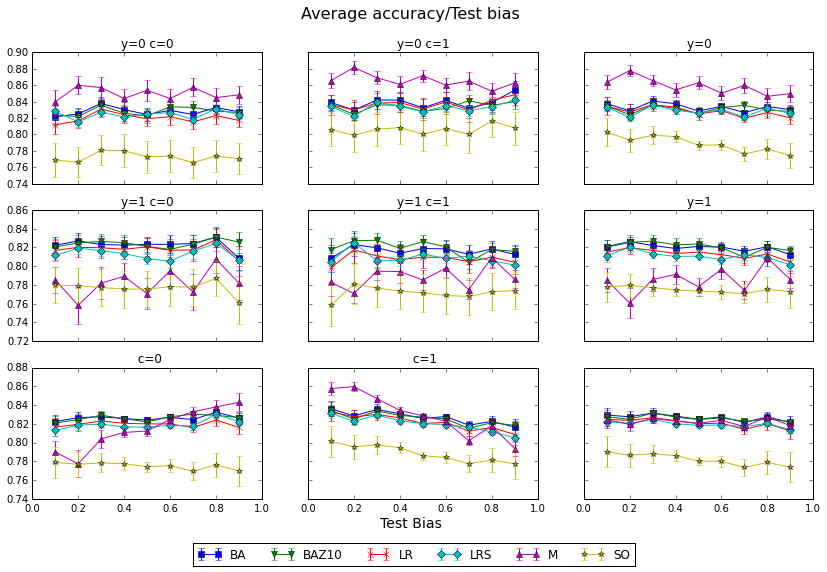

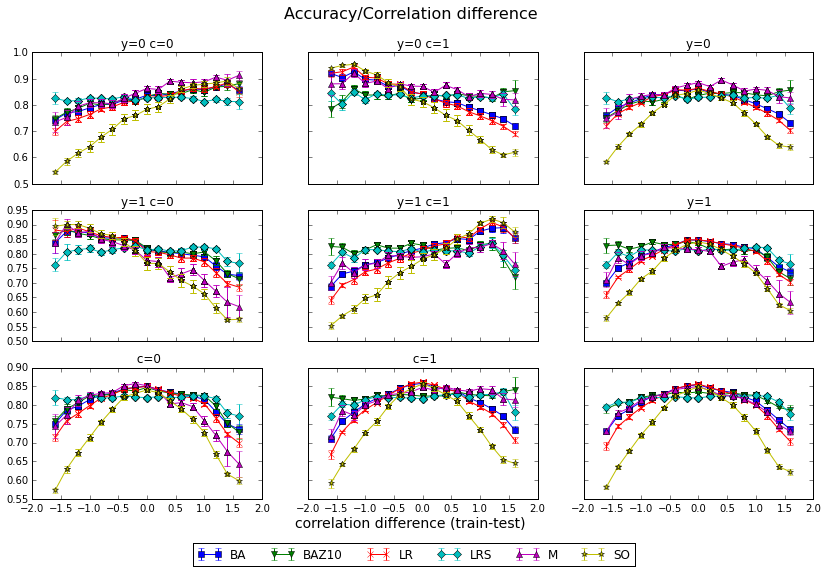

In [885]:
test_bias_axis2 = (test_biases2, 'test_bias', 'Test Bias')
corr_diff_axis2 = (corr_diffs2, 'corr_diff', 'correlation difference (train-test)')

plot_all_accuracies(accuracies2, test_bias_axis2, title='Average accuracy/Test bias', xlim=[0,1])#, keys=to_plot)
plot_all_accuracies(accuracies2, corr_diff_axis2, title='Accuracy/Correlation difference')#, keys=to_plot)

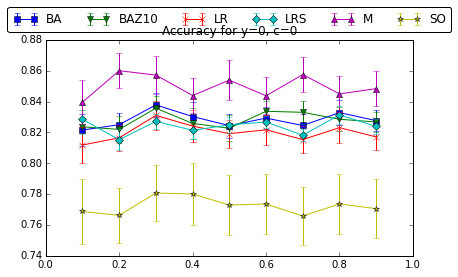

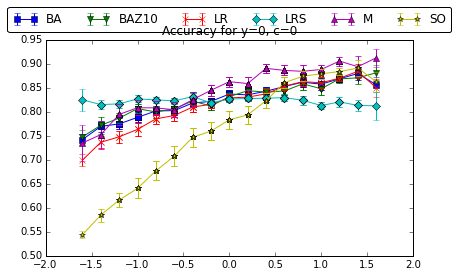

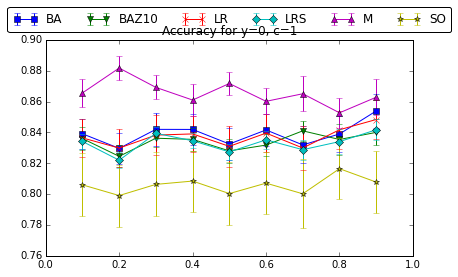

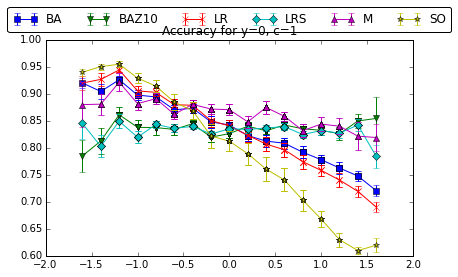

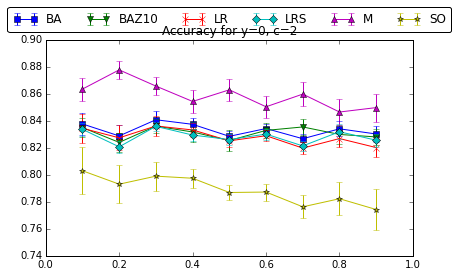

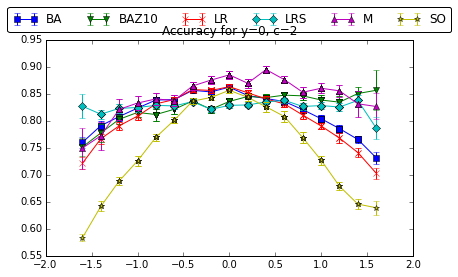

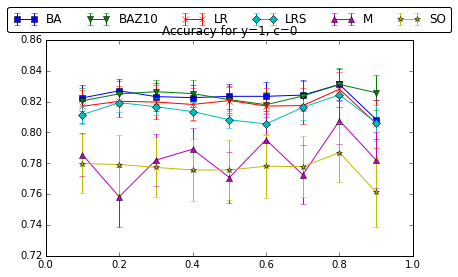

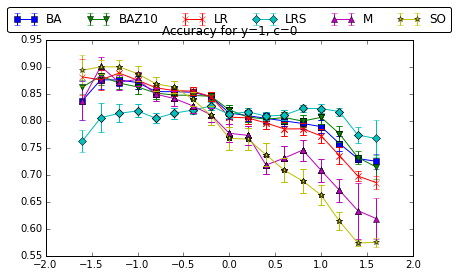

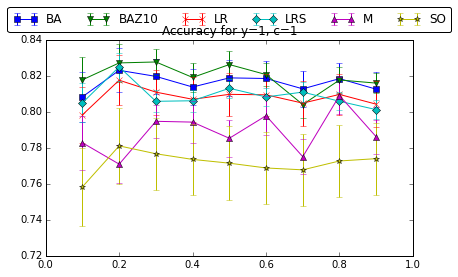

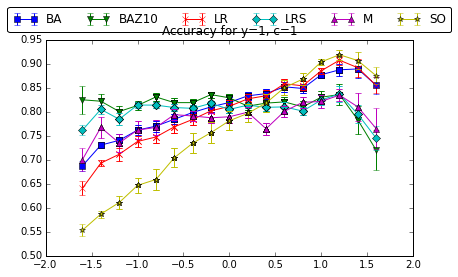

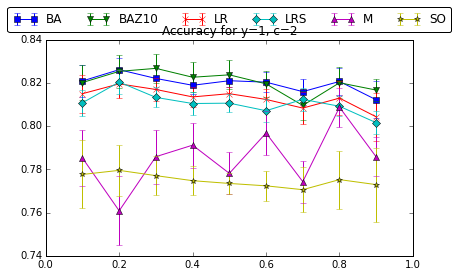

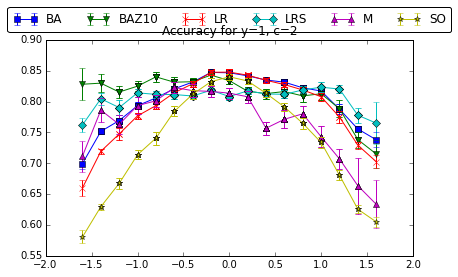

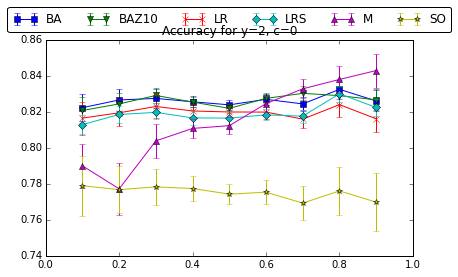

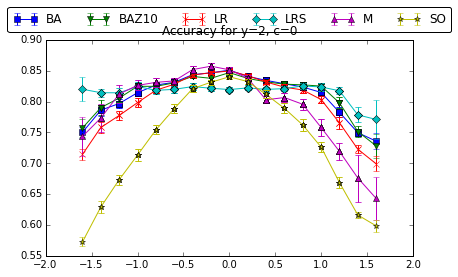

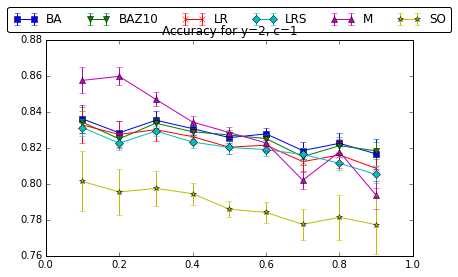

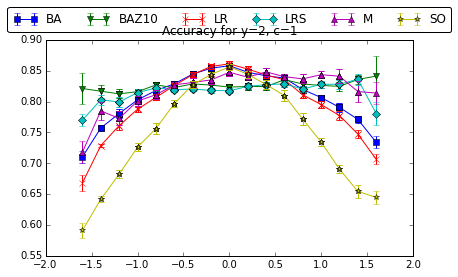

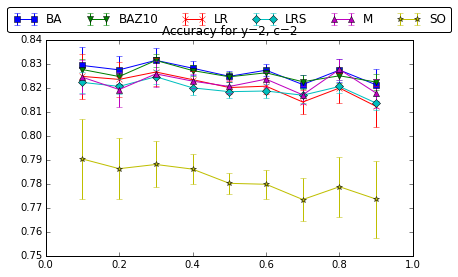

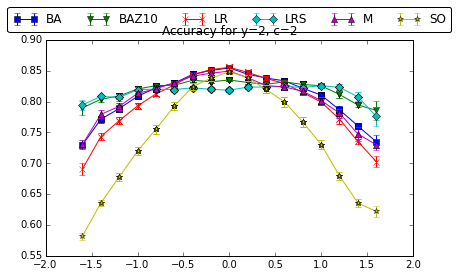

In [886]:
for y in range(3):
    for c in range(3):
        plot_accuracy(accuracies2, test_bias_axis2, y=y, c=c, xlim=[0,1])#, keys=['lr subsampling', 'backdoor adjustment'])
        plot_accuracy(accuracies2, corr_diff_axis2, y=y, c=c)#, keys=['lr subsampling', 'backdoor adjustment'])

#### Most changing features

In [624]:
%run most_changing_coef.py

bias = 0.1


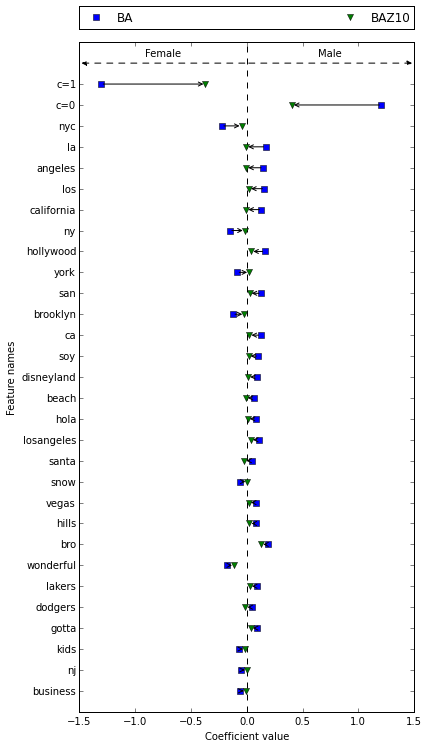

bias = 0.5


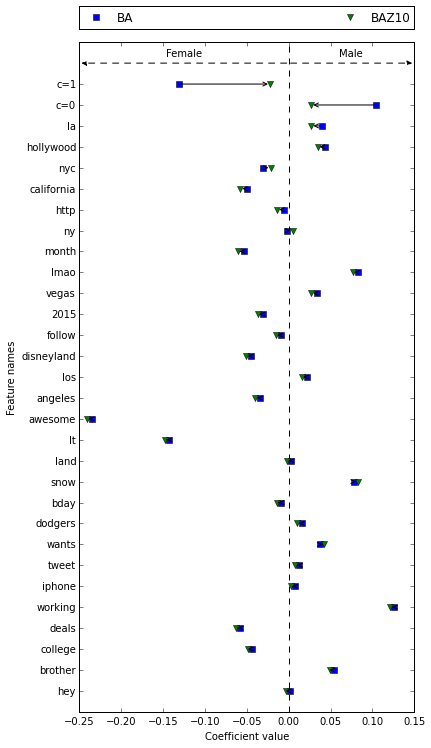

bias = 0.9


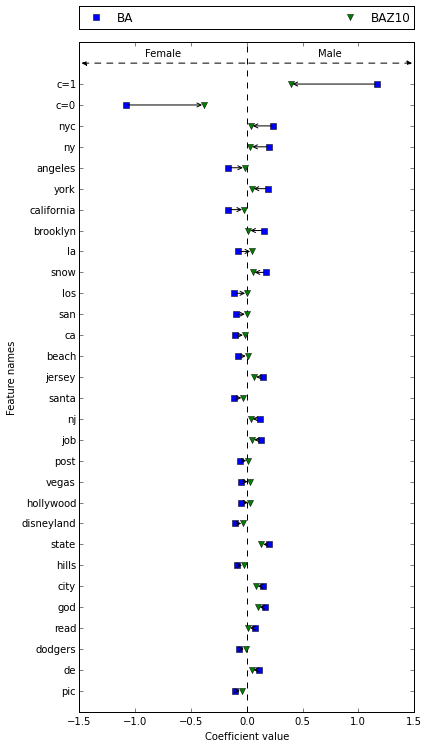

In [625]:
params = dict(data=data2,
              n=30,
              models=[(backdoor_adjustment, 'BA', 'bs'),(backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.1,.5,.9],
              size=800,
              transformation=most_changing_coef,
              class_labels=['Female', 'Male'],
              feature_names=np.hstack([data.feature_names, ['c=0', 'c=1']]))
changing_coef_plot(**params)

bias = 0.1


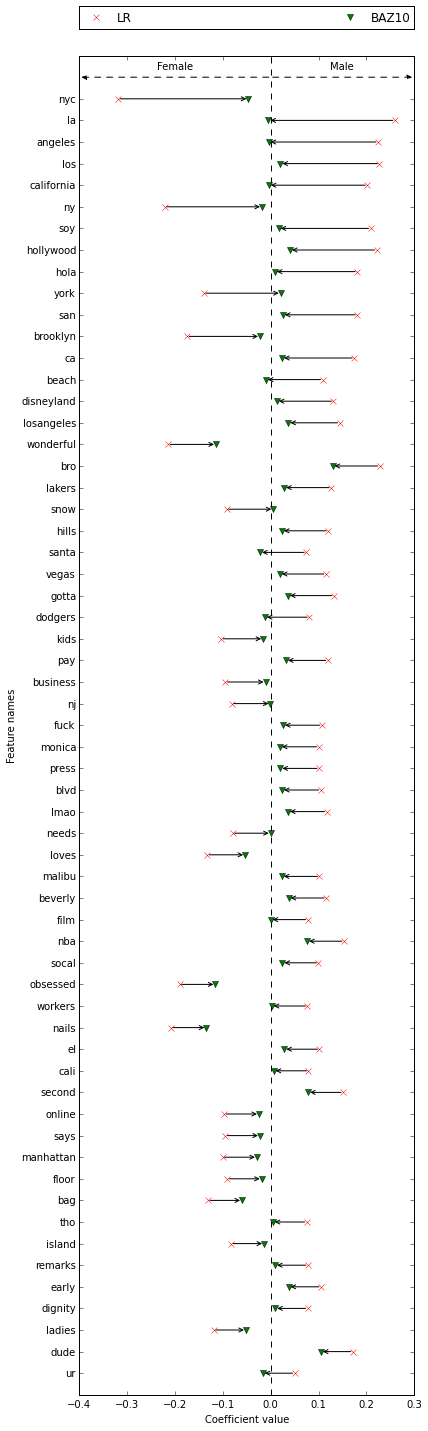

bias = 0.5


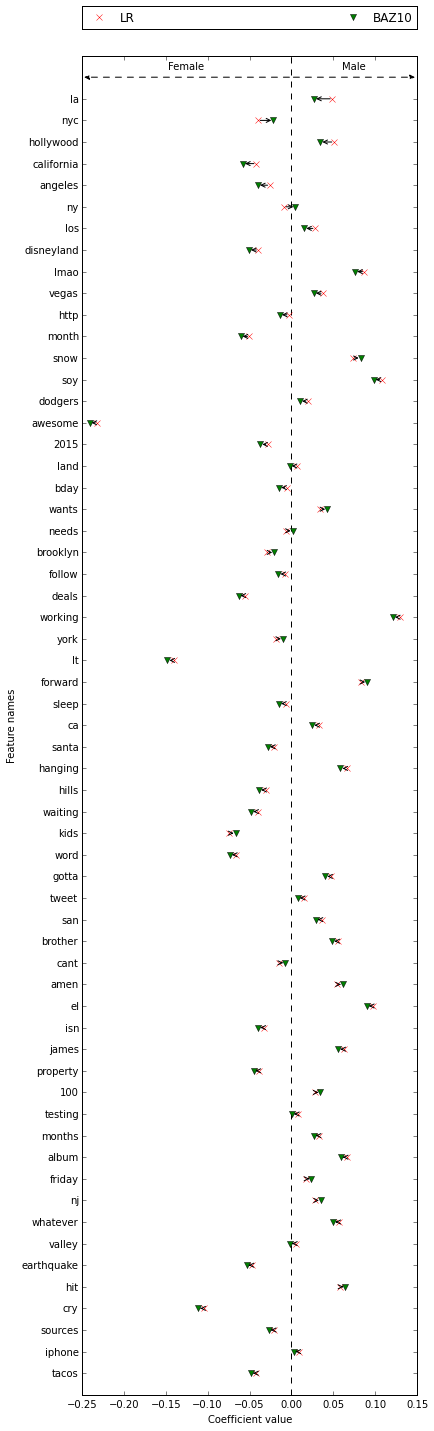

bias = 0.9


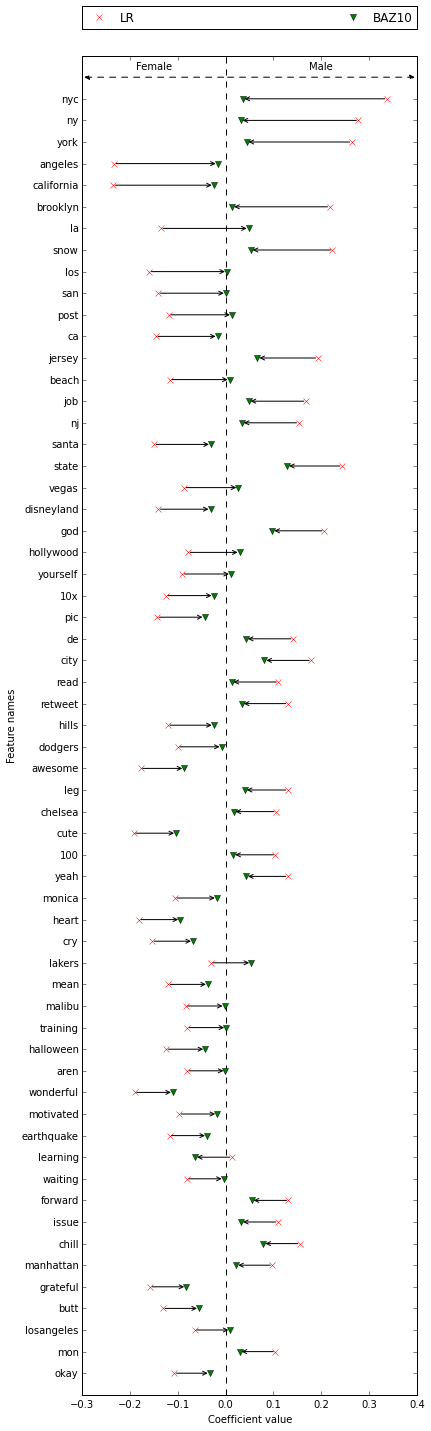

In [724]:
params = dict(data=data2,
              n=60,
              models=[(lr, 'LR', 'rx'), (backdoor_adjustment_Z10, 'BAZ10', 'gv')],
              biases=[.1,.5,.9],
              size=800,
              transformation=most_changing_coef,
              class_labels=['Female', 'Male'])
changing_coef_plot(**params)

#### Top terms table

In [640]:
%run top_terms_table.py

In [641]:
do_top_coef_table(data2, lr, 5, 800, 10, np.random.RandomState(111191), 1., feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['disneyland' 'angeles' 'brooklyn' 'nj' 'socal' 'losangeles' 'dodger'
 'dodgers' 'mta' 'freeway' 'dtla' 'los' 'monica' 'nyc' 'bronx' 'ny'
 'burbank' 'pasadena' 'williamsburg' 'california' 'malibu' 'manhattan'
 'midtown' 'queens' 'venice' 'ucla' 'anaheim' 'staten' 'usc' 'canyon'
 'upstate' 'blizzard' 'ktla' 'yankee' 'mets' 'sandy' 'citi' 'ca' 'newark'
 'tfti' 'hollywood' 'soho' 'hoboken' 'diego' 'beverly' 'metlife' 'barclays'
 'tribeca' 'albany' 'weho' 'boba' 'abc7' 'lacma' 'yorkers' 'wilshire'
 'yankees' 'cali' 'asada' 'hudson' 'laguardia' 'lapd' 'lirr' 'york' 'lga'
 'bk' 'glendale' 'nypd' 'redondo' '405' 'newyork' 'astoria' 'lakers'
 'santamonica' 'ventura' 'snowing' 'nymag' 'fucken' 'earthquake' 'blvd'
 'sandiego' 'greenwich' 'san' 'nycmayorsoffice' 'snowday' 'culver' 'sd'
 'hills' 'broadway' 'coney' 'bowery' 'latimes' 'madison' 'runyon'
 'griffith' 'seamless' 'tamales' 'gothamist' 'cal' 'nbcla' 'yorker'
 'shove

In [629]:
do_top_coef_table(data2, backdoor_adjustment, 5, 800, 10, np.random.RandomState(111191), 1., feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['disneyland' 'angeles' 'brooklyn' 'nj' 'socal' 'losangeles' 'dodger'
 'dodgers' 'mta' 'freeway' 'dtla' 'los' 'monica' 'nyc' 'bronx' 'ny'
 'burbank' 'pasadena' 'williamsburg' 'california' 'malibu' 'manhattan'
 'midtown' 'queens' 'venice' 'ucla' 'anaheim' 'staten' 'usc' 'canyon'
 'upstate' 'blizzard' 'ktla' 'yankee' 'mets' 'sandy' 'citi' 'ca' 'newark'
 'tfti' 'hollywood' 'soho' 'hoboken' 'diego' 'beverly' 'metlife' 'barclays'
 'tribeca' 'albany' 'weho' 'boba' 'abc7' 'lacma' 'yorkers' 'wilshire'
 'yankees' 'cali' 'asada' 'hudson' 'laguardia' 'lapd' 'lirr' 'york' 'lga'
 'bk' 'glendale' 'nypd' 'redondo' '405' 'newyork' 'astoria' 'lakers'
 'santamonica' 'ventura' 'snowing' 'nymag' 'fucken' 'earthquake' 'blvd'
 'sandiego' 'greenwich' 'san' 'nycmayorsoffice' 'snowday' 'culver' 'sd'
 'hills' 'broadway' 'coney' 'bowery' 'latimes' 'madison' 'runyon'
 'griffith' 'seamless' 'tamales' 'gothamist' 'cal' 'nbcla' 'yorker'
 'shove

In [630]:
do_top_coef_table(data2, backdoor_adjustment_Z10, 5, 800, 10, np.random.RandomState(111191), 1., feature_names)

Top 1.00 % of features that are the most correlated with the confounder:
['disneyland' 'angeles' 'brooklyn' 'nj' 'socal' 'losangeles' 'dodger'
 'dodgers' 'mta' 'freeway' 'dtla' 'los' 'monica' 'nyc' 'bronx' 'ny'
 'burbank' 'pasadena' 'williamsburg' 'california' 'malibu' 'manhattan'
 'midtown' 'queens' 'venice' 'ucla' 'anaheim' 'staten' 'usc' 'canyon'
 'upstate' 'blizzard' 'ktla' 'yankee' 'mets' 'sandy' 'citi' 'ca' 'newark'
 'tfti' 'hollywood' 'soho' 'hoboken' 'diego' 'beverly' 'metlife' 'barclays'
 'tribeca' 'albany' 'weho' 'boba' 'abc7' 'lacma' 'yorkers' 'wilshire'
 'yankees' 'cali' 'asada' 'hudson' 'laguardia' 'lapd' 'lirr' 'york' 'lga'
 'bk' 'glendale' 'nypd' 'redondo' '405' 'newyork' 'astoria' 'lakers'
 'santamonica' 'ventura' 'snowing' 'nymag' 'fucken' 'earthquake' 'blvd'
 'sandiego' 'greenwich' 'san' 'nycmayorsoffice' 'snowday' 'culver' 'sd'
 'hills' 'broadway' 'coney' 'bowery' 'latimes' 'madison' 'runyon'
 'griffith' 'seamless' 'tamales' 'gothamist' 'cal' 'nbcla' 'yorker'
 'shove